https://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/

https://stackoverflow.com/questions/28845825/pandas-python-convert-hhmmss-into-seconds-in-aggegate-csv-file



In [1]:
from scipy import stats
import pandas as pd
import numpy as np

def targetEval(df):
    """
    Evaluation of the target
    """
    seconds_hours_exit = df.filter(like='seconds_time_exit_')
    x_exit = df.filter(like='x_exit')
    y_exit = df.filter(like='y_exit')
    
    col_names_hours = ['seconds_time_exit_{0}'.format(x) for x in range(len(seconds_hours_exit.keys()))]
    col_names_x = ['x_exit_{0}'.format(x) for x in range(len(x_exit.keys()))]
    col_names_y = ['y_exit_{0}'.format(y) for y in range(len(y_exit.keys()))]
    
    seconds_hours_exit = seconds_hours_exit[col_names_hours].copy()
    x_exit = x_exit[col_names_x].copy()
    y_exit = y_exit[col_names_y].copy()
    
    last_seconds_hours_exit = [x[df.vector_lenght[i]-1] for i, x in enumerate(seconds_hours_exit.values)]
    last_x_exit = [x[df.vector_lenght[i]-1] for i, x in enumerate(x_exit.values)]
    last_y_exit = [x[df.vector_lenght[i]-1] for i, x in enumerate(y_exit.values)]

    assert len(last_seconds_hours_exit) == len(last_x_exit)
    assert len(last_seconds_hours_exit) == len(last_y_exit)
        
    result = []
    for x in range(len(last_x_exit)):
        if ((last_seconds_hours_exit[x]>=(15*60*60 + 0*60 + 0*60)) & 
            (last_seconds_hours_exit[x]<=(15*60*60 + 59*60 + 59*60)) & 
            (last_x_exit[x] < 3770901.5068) & (last_x_exit[x] > 3750901.5068) &
            (abs(last_y_exit[x]) < 19268905.6133) & (abs(last_y_exit[x]) > 19208905.6133)):
            result.append(1)
        else:
            result.append(0)
    return result

def center_distance(df, entry):
    def center_measure(x,y):
        x_center = (3750901.5068+3770901.5068)/2
        y_center = (-19268905.6133-19208905.6133)/2
        return ((x_center-x.values)**2+(y_center-y.values)**2)**(1/2)
    
    x_entrys = df.filter(like='x_entry').copy()
    y_entrys = df.filter(like='y_entry').copy()
    x_exit = df.filter(like='x_exit').copy()
    y_exit = df.filter(like='y_exit').copy()
    achados=0
    if entry == 'in':
        return center_measure(x_entrys['x_entry_0'], y_entrys['y_entry_0'])
    elif entry == 'out':
        last_keys = []
        for y in range(len(x_exit)):
            vector = list(zip(x_exit.iloc[y].keys(), x_exit.iloc[y]))
            vector.reverse()
            for i, x in enumerate(vector):
                if (x[1] == 0.0):
                    last_keys.append(i)
                    break
                elif i==(len(vector)-1):
                    last_keys.append(i)
                    break
                else:
                    pass
            assert len(last_keys)==(len(center_measure(x_exit['x_exit_0'][:y], y_exit['y_exit_0'][:y]))+1)
        return last_keys, center_measure(x_exit['x_exit_0'], y_exit['y_exit_0'])
    else:
        return None
    
def time_HHMMSS_to_seconds(train_data):
    def to_sec(x):
        time = str(x).split(':')
        if len(time) != 3:
            return None
        else:
            return float(time[0])*60*60+float(time[1])*60+float(time[2])
    
    keys_entry = ['time_entry_{0}'.format(str(int(x))) for x in range(0, len(train_data.filter(like='time_entry_').keys()))]
    
    for key in keys_entry:
        train_data['seconds_{0}'.format(key)] = train_data[key].apply(lambda x: to_sec(x))
    keys_exit = train_data.filter(like='time_exit').keys()
    for key in keys_exit:
        train_data['seconds_{0}'.format(key)] = train_data[key].apply(lambda x: to_sec(x))
    return train_data.drop(keys_entry, axis=1).drop(keys_exit, axis=1)

def time_analysis(df):
    ttime = []
    meantime = []
    for x in range(len(df)):
        vl = df['vector_lenght'][x]
        aa = df['seconds_time_exit_{0}'.format(vl)][x] - df['seconds_time_entry_0'][x]
        ttime.append(aa)
        bb = 0
        for y in range(vl):
            bb+=df['seconds_time_exit_{0}'.format(vl)][x] - df['seconds_time_entry_0'][x]
        meantime.append(bb/(vl+1))
    return ttime, meantime

def distance_analysis(df):
    tdistance = []
    adistance = []
    for x in range(len(df)):
        vl = df['vector_lenght'][x]-1
        xx = df['x_exit_{0}'.format(vl)][x] - df['x_entry_0'][x]
        yy = df['y_exit_{0}'.format(vl)][x] - df['y_entry_0'][x]
        tdistance.append((xx**2+yy**2)**(1/2))
        zz = 0
        for y in range(vl):
            zz+=df['x_exit_{0}'.format(vl)][x] - df['seconds_time_entry_0'][x]
        adistance.append(zz/(vl+1))
    return tdistance, adistance

# Loading data
train_data = pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1)

def clean(train_data):
    # Unstacking columns
    reordering = train_data.groupby('hash').cumcount()
    train_data = train_data.set_index(['hash', reordering]).unstack().sort_index(1, level=1, ascending = False)

    train_data.columns = ['_'.join(map(str,i)) for i in train_data.columns]
    train_data.reset_index()
    train_data.fillna(0, inplace = True)

    # Converting time hh:mm:ss to seconds
    train_data = time_HHMMSS_to_seconds(train_data)
    train_data.fillna(0, inplace = True)

    train_data['entry_distance'] = center_distance(train_data, 'in')
    train_data['vector_lenght'], train_data['exit_distance'] = center_distance(train_data, 'out')

    train_data['city_center'] = targetEval(train_data)

    train_data['total_time'], train_data['mean_time_per_traj'] = time_analysis(train_data)

    train_data['total_distance'], train_data['average_distance'] = distance_analysis(train_data)

    train_data['average_velocity'] = train_data['total_time']/train_data['total_distance']

    # Columns unneeded
    to_drop = list(train_data.filter(like='trajectory_id').keys()) + ['city_center']
    # Removing outliers
    df = train_data.reset_index(drop=True).drop(to_drop, axis=1).copy()
    # no_outliers = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    no_outliers = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)].copy()

NameError: name 'bb' is not defined

In [36]:
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scaling
ss = StandardScaler()
# PCA
pca = PCA(random_state=420)
# Separating variables
# X = ss.fit_transform(pca.fit_transform(train_data.iloc[no_outliers.index].drop(to_drop, axis=1).values))
X = ss.fit_transform(train_data.iloc[no_outliers.index].drop(to_drop, axis=1).values)
y = train_data.iloc[no_outliers.index]['city_center']
# # split data into train and test sets
X_train, X_test,\
y_train, y_test = train_test_split(X,y,
                                   test_size=0.33,
                                   random_state=420)

Accuracy: 92.47472%
Recall: 83.85654%
F1: 85.80063%
True Positives: 9937 
True Negatives: 30480 
False Positives: 1376 
False Negatives: 1913


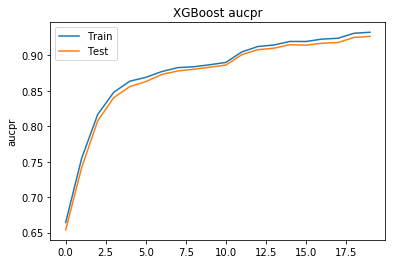

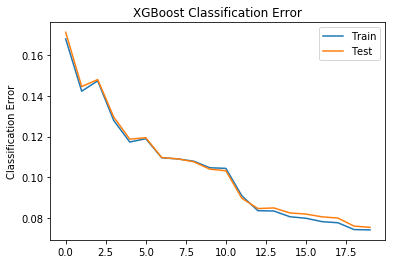

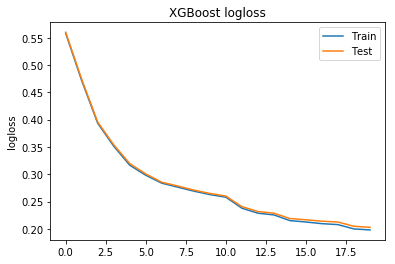

In [39]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from matplotlib import pyplot
from xgboost import XGBClassifier

# fit model on training data
xgb_clf = XGBClassifier(max_depth=3, learning_rate=0.5, n_estimators=20, verbosity=1, silent=0, 
                        objective='binary:logistic', booster='gbtree', n_jobs=-1, gamma=5,
                        min_child_weight=3, max_delta_step=1, subsample=1, colsample_bytree=1, 
                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=1, reg_lambda=1, 
                        scale_pos_weight=1, base_score=0.5, random_state=420, missing=None)

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["aucpr", "error", "logloss"]

xgb_clf.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=0)

# make predictions for test data
y_pred = xgb_clf.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))
recall = recall_score(y_test, predictions)
print("Recall: %.5f%%" % (recall * 100.0))
f_score = f1_score(y_test, predictions)
print("F1: %.5f%%" % (f_score * 100.0))
tn, fp, fn, tp = confusion_matrix(y_test, xgb_clf.predict(X_test)).ravel()
print('True Positives:', tp,
      '\nTrue Negatives:', tn,
      '\nFalse Positives:', fp,
      '\nFalse Negatives:', fn)

# retrieve performance metrics
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot aucpr
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax.legend()
pyplot.ylabel('aucpr')
pyplot.title('XGBoost aucpr')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('logloss')
pyplot.title('XGBoost logloss')
pyplot.show()

In [40]:
pd.DataFrame(list(zip(list(train_data.iloc[no_outliers.index].drop(to_drop, axis=1).keys()),
                      pca.explained_variance_ratio_*100.0,
                      xgb_clf.feature_importances_)), columns=['feature','PCA explained variance in %','XGBoost feature importances'])

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [45]:
pd.DataFrame(list(zip(list(train_data.iloc[no_outliers.index].drop(to_drop, axis=1).keys()),
                      xgb_clf.feature_importances_)), columns=['feature','XGBoost feature importances']).sort_values('XGBoost feature importances', ascending=False)

,feature,XGBoost feature importances
182,exit_distance,0.218333
119,y_exit_2,0.112697
121,x_exit_2,0.083638
112,y_exit_3,0.058659
180,entry_distance,0.057039
128,x_exit_1,0.045486
185,total_distance,0.042657
176,seconds_time_exit_3,0.034421
98,y_exit_5,0.033146
174,seconds_time_exit_5,0.032469


In [82]:
def test_distance_analysis(df):
    tdistance = []
    adistance = []
    for x in range(len(df)):
        vl = df['vector_lenght'][x]
        xx = df['x_exit_{0}'.format(vl)][x] - df['x_entry_0'][x]
        yy = df['y_exit_{0}'.format(vl)][x] - df['y_entry_0'][x]
        tdistance.append((xx**2+yy**2)**(1/2))
        zz = 0
        for y in range(vl):
            zz+=df['x_exit_{0}'.format(vl)][x] - df['seconds_time_entry_0'][x]
        adistance.append(zz/(vl+1))
    return tdistance, adistance

test_data = pd.read_csv('data_test.csv').drop('Unnamed: 0', axis=1)

# Unstacking columns
reordering = test_data.groupby('hash').cumcount()
test_data = test_data.set_index(['hash', reordering]).unstack().sort_index(1, level=1, ascending = False)

test_data.columns = ['_'.join(map(str,i)) for i in test_data.columns]
test_data.reset_index()
test_data.fillna(0, inplace = True)

# Converting time hh:mm:ss to seconds
test_data = time_HHMMSS_to_seconds(test_data)
test_data.fillna(0, inplace = True)

test_data['entry_distance'] = center_distance(test_data, 'in')
test_data['vector_lenght'], test_data['exit_distance'] = center_distance(test_data, 'out')

# test_data['city_center'] = targetEval(test_data)

test_data['total_time'], test_data['mean_time_per_traj'] = time_analysis(test_data)

test_data['total_distance'], test_data['average_distance'] = test_distance_analysis(test_data)

test_data['average_velocity'] = test_data['total_time']/test_data['total_distance']

In [124]:
l = [x[-test_data['vector_lenght'][i]] for i, x in enumerate(test_data.filter(like='trajectory_id_').values)]

In [128]:
test_data = test_data.fillna(0).reset_index(drop=True).copy()

to_drop_test = list(train_data.filter(like='trajectory_id').keys())

test_data['target'] = xgb_clf.predict(ss.transform(test_data.copy().drop(to_drop_test,axis=1)))

submission = test_data['target'].copy()
submission['id'] = l
submission = submission[['id', 'target']].copy()
submission.to_csv('thirdtry.csv', index=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


ValueError: operands could not be broadcast together with shapes (33515,189) (188,) (33515,189) 

In [68]:
aaa = test_data[list(train_data.filter(like='trajectory_id').keys())+['target']].stack()
# test_data[list(train_data.filter(like='target').keys())].stack()

In [112]:
flat_list

['traj_00032f51796fd5437b238e3a9823d13d_31_4',
 'traj_00032f51796fd5437b238e3a9823d13d_31_3',
 'traj_00032f51796fd5437b238e3a9823d13d_31_2',
 'traj_00032f51796fd5437b238e3a9823d13d_31_0',
 'traj_000479418b5561ab694a2870cc04fd43_25_6',
 'traj_000479418b5561ab694a2870cc04fd43_25_0',
 'traj_000506a39775e5bca661ac80e3f466eb_29_2',
 'traj_000506a39775e5bca661ac80e3f466eb_29_1',
 'traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_1',
 'traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_0',
 'traj_00063a4f6c12e1e4de7d876580620667_3_3',
 'traj_00063a4f6c12e1e4de7d876580620667_3_2',
 'traj_00063a4f6c12e1e4de7d876580620667_3_1',
 'traj_0006535be25bb52dd06983447880c964_5_10',
 'traj_0006535be25bb52dd06983447880c964_5_8',
 'traj_0006535be25bb52dd06983447880c964_5_6',
 'traj_0006535be25bb52dd06983447880c964_5_5',
 'traj_0006535be25bb52dd06983447880c964_5_0',
 'traj_0006f84bb33ec929d1cda7686f861d0a_31_2',
 'traj_0006f84bb33ec929d1cda7686f861d0a_31_1',
 'traj_0006f84bb33ec929d1cda7686f861d0a_31_0',
 'traj_00093ae562586ae

In [340]:
def scores_eval(y_test, predictions):
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.5f%%" % (accuracy * 100.0))
    recall = recall_score(y_test, predictions)
    print("Recall: %.5f%%" % (recall * 100.0))
    f_score = f1_score(y_test, predictions)
    print("F1: %.5f%%" % (f_score * 100.0))
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print('True Positives:', tp,
          '\nTrue Negatives:', tn,
          '\nFalse Positives:', fp,
          '\nFalse Negatives:', fn)
    
submission['real'] = targetEval(test_data)
scores_eval(submission['real'], submission['target'])

Accuracy: 100.00000%
Recall: 0.00000%
F1: 0.00000%


ValueError: not enough values to unpack (expected 4, got 1)

Accuracy: 99.71462%
Recall: 96.27444%
F1: 95.92062%
True Positives: 2610 
True Negatives: 74958 
False Positives: 121 
False Negatives: 101


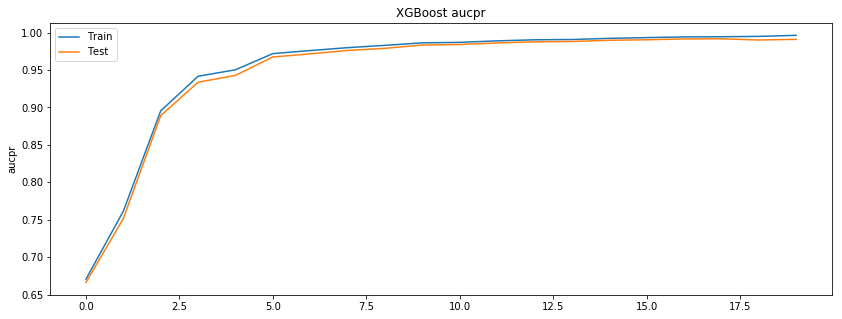

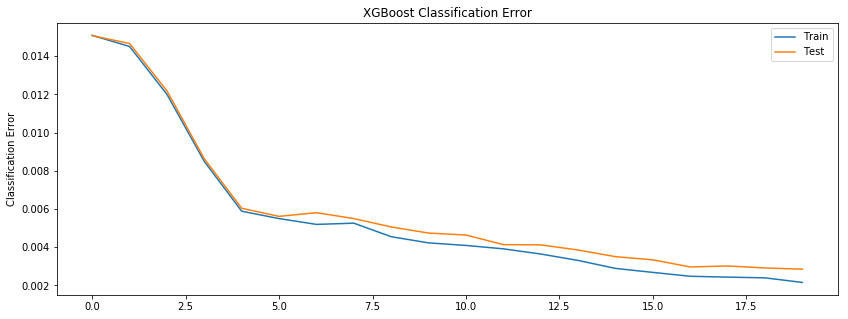

In [286]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1)

def targetEval(df):
    """
    Evaluation of the target
    """
    hours_exit = df['hours_exit']
    x_exit = df['x_exit']
    y_exit = df['y_exit']
    
    result = []
    
    for x in range(len(df)):
        if ((hours_exit[x]==15) & 
            (x_exit[x] < 3770901.5068) & (x_exit[x] > 3750901.5068) &
            (y_exit[x] > -19268905.6133) & (y_exit[x] < -19208905.6133)):
            result.append(1)
        else:
            result.append(0)
    return result

def hours_split_and_time_diff(df):
    """
    Splitting the time and calculating the difference in seconds
    """
    hours_entry, \
    minutes_entry, \
    seconds_entry = zip(*df['time_entry'].map(lambda x: x.split(':')).values.tolist())
    
    df['hours_entry']   = [int(x) for x in hours_entry]
    df['minutes_entry'] = [int(x) for x in minutes_entry]
    df['seconds_entry'] = [int(x) for x in seconds_entry]
    
    hours_exit, \
    minutes_exit, \
    seconds_exit = zip(*df['time_exit'].map(lambda x: x.split(':')).values.tolist())
    
    df['hours_exit']   = [int(x) for x in hours_exit]
    df['minutes_exit'] = [int(x) for x in minutes_exit]
    df['seconds_exit'] = [int(x) for x in seconds_exit]

    hours_diff_in_seconds = (np.array([int(x) for x in hours_exit]) - np.array([int(x) for x in hours_entry]))*60
    minutes_diff_in_seconds = ((np.array([int(x) for x in minutes_entry])-60)*(-1) + np.array([int(x) for x in minutes_exit]))*60
    seconds_diff = np.array([int(x) for x in seconds_exit]) - np.array([int(x) for x in seconds_entry])

    df['time_diff_in_seconds'] = hours_diff_in_seconds + minutes_diff_in_seconds + seconds_diff
    
    return df.drop(['time_entry', 'time_exit'], axis=1).copy()

def x_measure(x):
    """
    Measuring the x distance from the city center
    """
    if (x > 3770901.5068):
        return abs(x)-3770901.5068
    elif (x < 3750901.5068):
        return abs(x)-3750901.5068
    else:
        return 0

def y_measure(y):
    """
    Measuring the y distance from the city center
    """
    if (y < -19268905.6133):
        return abs(y)-19268905.6133
    elif (y > -19208905.6133):
        return abs(y)-19208905.6133
    else:
        return 0

def distance_to_center(df, label):
    """
    Measuring the x or y distance from the city center
    """
    if label[:1] == 'x':
        return df[label].apply(lambda x: x_measure(x))
    else:
        return df[label].apply(lambda y: y_measure(y))

def euclidian_distance(x, y):
    """
    Measuring the euclidian distance
    """
    return (x**2+y**2)**(1/2)

def dot_distance(x1,y1,x2,y2):
    """
    Measuring the distance between dots
    """
    return ((x2-x1)**2+(y2-y1)**2)**(1/2)

def average_velocity(traj_lenght,time_spent):
    """
    Average velocity calculation
    """
    return traj_lenght/time_spent
    
train_data = hours_split_and_time_diff(train_data)

train_data['city_center'] = targetEval(train_data)

# train_data['x_entry_distance'] = distance_to_center(train_data, 'x_entry')
# train_data['y_entry_distance'] = distance_to_center(train_data, 'x_entry')

# train_data['x_exit_distance'] = distance_to_center(train_data, 'y_exit')
# train_data['y_exit_distance'] = distance_to_center(train_data, 'y_exit')

# train_data['entry_distance_to_center'] = euclidian_distance(train_data['x_entry_distance'], train_data['y_entry_distance'])
# train_data['exit_distance_to_center'] = euclidian_distance(train_data['x_exit_distance'], train_data['y_exit_distance'])

# train_data['traj_lenght'] = dot_distance(train_data['x_entry_distance'],
#                                          train_data['y_entry_distance'],
#                                          train_data['x_exit_distance'],
#                                          train_data['y_exit_distance'])

# train_data['average_velocity'] = average_velocity(train_data['traj_lenght'], train_data['time_diff_in_seconds'])

train_data = train_data.dropna().reset_index(drop=True).copy()

import sys
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Removing outliers
df = train_data.drop(['hash', 'trajectory_id','city_center'], axis=1).copy()
no_outliers = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
# Scaling
ss = StandardScaler()
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components='mle', random_state=420)
# Separating variables
X = ss.fit_transform(pca.fit_transform(train_data.iloc[no_outliers.index].drop(['hash', 'trajectory_id','city_center'], axis=1)))
# X = ss.fit_transform(train_data.iloc[no_outliers.index].drop(['hash', 'trajectory_id','city_center'], axis=1))
y = train_data.iloc[no_outliers.index]['city_center']
# # split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.33,
                                                    random_state=420)

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from matplotlib import pyplot
from xgboost import XGBClassifier

# fit model on training data
xgb_clf = XGBClassifier(max_depth=3, learning_rate=1, n_estimators=20, verbosity=1, silent=0, 
                        objective='binary:logistic', booster='gbtree', n_jobs=-1, gamma=1,
                        min_child_weight=3, max_delta_step=1, subsample=1, colsample_bytree=1, 
                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=1, reg_lambda=0.7, 
                        scale_pos_weight=1, base_score=0.5, random_state=420, missing=None)

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["aucpr", "error"]

xgb_clf.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=0)

# make predictions for test data
y_pred = xgb_clf.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))
recall = recall_score(y_test, predictions)
print("Recall: %.5f%%" % (recall * 100.0))
f_score = f1_score(y_test, predictions)
print("F1: %.5f%%" % (f_score * 100.0))
tn, fp, fn, tp = confusion_matrix(y_test, xgb_clf.predict(X_test)).ravel()
print('True Positives:', tp,
      '\nTrue Negatives:', tn,
      '\nFalse Positives:', fp,
      '\nFalse Negatives:', fn)

# retrieve performance metrics
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot aucpr
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax.legend()
fig.set_figheight(5)
fig.set_figwidth(14)
pyplot.ylabel('aucpr')
pyplot.title('XGBoost aucpr')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
fig.set_figheight(5)
fig.set_figwidth(14)
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

# # plot log loss
# fig, ax = pyplot.subplots()
# ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
# ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
# ax.legend()
# fig.set_figheight(5)
# fig.set_figwidth(14)
# pyplot.ylabel('logloss')
# pyplot.title('XGBoost logloss')
# pyplot.show()

In [287]:
pd.DataFrame(list(zip(list(train_data.iloc[no_outliers.index].drop(['hash', 'trajectory_id','city_center'], axis=1).keys()),
                      pca.explained_variance_ratio_*100.0,
                      xgb_clf.feature_importances_)), columns=['feature','PCA explained variance in %','XGBoost feature importances'])

,feature,PCA explained variance in %,XGBoost feature importances
0,vmax,9.458064e+01,0.310763
1,vmin,4.093636e+00,0.156270
2,vmean,1.280441e+00,0.184073
3,x_entry,4.249952e-02,0.018073
4,y_entry,2.775455e-03,0.026950
5,x_exit,4.634605e-06,0.039145
6,y_exit,4.423491e-06,0.000000
7,hours_entry,8.104355e-07,0.005335
8,minutes_entry,4.572203e-07,0.060503
9,seconds_entry,2.346617e-07,0.135321


In [ ]:
pd.DataFrame(list(zip(list(train_data.iloc[no_outliers.index].drop(['hash', 
                                                                    'trajectory_id',
                                                                    'city_center'], axis=1).keys()),
                      xgb_clf.feature_importances_)), columns=['feature',
                                                               'XGBoost feature importances'])

In [328]:
from sklearn.ensemble import RandomForestClassifier

ensemble_clf = RandomForestClassifier(n_estimators=50,verbose=True, n_jobs=-1, random_state=0, class_weight='balanced')
ensemble_clf.fit(X_train, y_train.ravel())
print(f1_score(y_test, ensemble_clf.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, ensemble_clf.predict(X_test)).ravel()
print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)

# from sklearn.model_selection import cross_val_score

# # 10-Fold Cross validation
# print(np.mean(cross_val_score(ensemble_clf, X, y, cv=5)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


0.961260919103684
tn: 75055 fp: 24 fn: 180 tp: 2531


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished


In [336]:
pd.DataFrame(list(zip(list(train_data.iloc[no_outliers.index].drop(['hash', 'trajectory_id','city_center'], axis=1).keys()),
                      ensemble_clf.feature_importances_)), columns=['feature','Ensemble feature importances'])

,feature,Ensemble feature importances
0,vmax,0.152762
1,vmin,0.060942
2,vmean,0.043891
3,x_entry,0.017520
4,y_entry,0.024241
5,x_exit,0.003161
6,y_exit,0.002114
7,hours_entry,0.019877
8,minutes_entry,0.037691
9,seconds_entry,0.528765


In [329]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=350, learning_rate=0.01, random_state=0).fit(X_train, y_train)
print(f1_score(y_test, gbc.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, gbc.predict(X_test)).ravel()
print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)

0.9274668630338734
tn: 74877 fp: 202 fn: 192 tp: 2519


In [338]:
pd.DataFrame(list(zip(list(train_data.iloc[no_outliers.index].drop(['hash', 'trajectory_id','city_center'], axis=1).keys()),
                      gbc.feature_importances_)), columns=['feature','GBC feature importances'])

,feature,GBC feature importances
0,vmax,0.512757
1,vmin,0.060317
2,vmean,0.104747
3,x_entry,0.003000
4,y_entry,0.000264
5,x_exit,0.001840
6,y_exit,0.000000
7,hours_entry,0.000108
8,minutes_entry,0.005401
9,seconds_entry,0.306907


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers import LSTM
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
from sklearn.metrics import precision_score
import tensorflow as tf

def recall_metric(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_metric(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

class F1(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return

f1 = F1((X_test, y_test))

# Building the model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(187,)))
# model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.1))
# then we finish again with completely standard Keras way
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer='adam', 
              metrics=[precision_metric, recall_metric, f1_metric])
model.summary()

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
# Training the model
model_scores = model.fit(X_train, y_train, epochs=100,batch_size=300,
                          validation_data=(X_test, y_test.ravel()),callbacks=[checkpointer, f1],
                          shuffle=True, verbose=True)
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train.ravel())
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, y_test.ravel())
print("\n Testing Accuracy:", score[1]) 

In [ ]:
from matplotlib import pyplot as plt
# summarize history for f1
plt.plot(model_scores.history['f1_metric'])
plt.plot(model_scores.history['val_f1_metric'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for prec
plt.plot(model_scores.history['precision_metric'])
plt.plot(model_scores.history['val_precision_metric'])
plt.title('model prec')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for recall
plt.plot(model_scores.history['recall_metric'])
plt.plot(model_scores.history['val_recall_metric'])
plt.title('model rec')
plt.ylabel('rec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_scores.history['loss'])
plt.plot(model_scores.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
